# Training Data without Cold Start 

In [74]:
import sys
import os

sys.path.append(os.path.abspath("../"))
import importlib
import data_processing  # Now you can import the module
importlib.reload(data_processing)


<module 'data_processing' from '/notebooks/ML-system-design/personalized-fashion-recommendations/data_processing.py'>

In [ ]:
customers, articles, transactions = data_processing.read_data(path="../data/")

In [125]:
train, test = data_processing.train_test_no_coldstart(transactions, factor=1000)

In [126]:
train.shape, test.shape

((5000, 5), (1000, 5))

In [128]:
train_xs_ys, test_xs_ys = data_processing.get_labels_no_coldstart(train), data_processing.get_labels_no_coldstart(test)

In [129]:
# Ensure that test set only contains users and articles seen in training:
train_users = set(train_xs_ys["customer_id"].unique())
test_users  = set(test_xs_ys["customer_id"].unique())
print (len(train_users), len(test_users), test_users.issubset(train_users))

train_articles = set(train_xs_ys["article_id"].unique())
test_articles  = set(test_xs_ys["article_id"].unique())
print (len(train_articles), len(test_articles), test_articles.issubset(train_articles))


1350 330 True
3073 646 True


In [78]:
train_xs_ys

,customer_id,article_id,label
0,fb5b040903fcf65532359894728a89c705404b4d720b0b...,696842001,1
1,06663dca9683cde0af30cb3237bf14820ed718d995f08d...,740943002,1
2,00831db1b63bf55122b12370414cd7c7c9f71ffd726152...,699075005,1
3,090bfae997e6a3157b9f6692275b670d57264ef91f14cb...,554477005,1
4,fbf378d7173f766f9eec57767a29db132fc8150d5720d2...,664319016,0
...,...,...,...
9995,09837315f5e960a0c3b55af52d08bbab48c7107027fdb2...,684212002,0
9996,0d0b3b98e8a8bab54a74b59a2aa4c2d4c6951d113c3704...,764998001,1
9997,0988ce127ab1e65a9f4f028385b349b86e782381e485ec...,734215003,1
9998,f7a68626df67e5ee8b4797cc8818e10b84a09918bbdc77...,386859007,1


# ID Hashing

(array([531., 157.,  84.,  46.,  14.,   5.,   5.,   2.,   1.,   2.]),
 array([ 2. , 10.6, 19.2, 27.8, 36.4, 45. , 53.6, 62.2, 70.8, 79.4, 88. ]),
 <BarContainer object of 10 artists>)

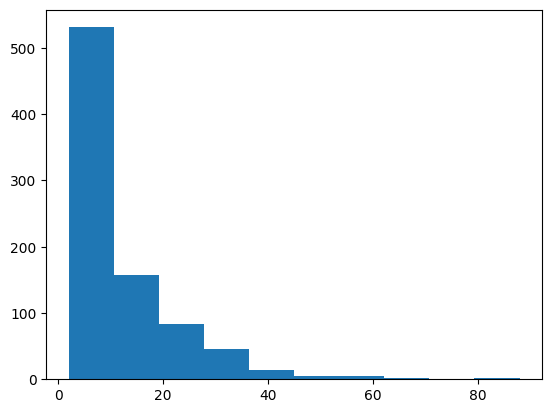

In [95]:
import matplotlib.pyplot as plt 

plt.hist(train_xs_ys.customer_id.apply(lambda x: hash(x) % 1350).value_counts())

In [99]:
train_xs_ys.customer_id.apply(lambda x: hash(x) % 1350).value_counts()[:20] 

customer_id
725     88
275     88
1230    76
1123    70
1046    68
1184    62
201     58
940     58
107     54
1209    54
941     50
1070    50
696     50
536     50
255     48
419     44
430     44
726     42
14      42
178     42
Name: count, dtype: int64

In [162]:
utoix, ixtou = {}, {}
for i, u in enumerate(train_xs_ys["customer_id"].unique()):
    utoix[u] = i
    ixtou[i] = u
    
atoix, ixtoa = {}, {}
for i, a in enumerate(train_xs_ys['article_id'].unique()):
    atoix[a] = i
    ixtoa[i] = a

# Training 

In [110]:
len(ixtou), len(atoix)

(1350, 3073)

In [111]:
embedding_size = 32

In [112]:
import torch

torch.Size([1350, 32])
torch.Size([3073, 32])


In [171]:
train_xs_ys = train_xs_ys.sample(frac=1, random_state=42)

In [209]:
xs, ys = train_xs_ys[['customer_id', 'article_id']], train_xs_ys[['label']]
xs['article_id'] = xs['article_id'].astype(int)
xs, ys = xs.to_numpy(), torch.tensor(ys.to_numpy())

/tmp/ipykernel_1069/3353662721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xs['article_id'] = xs['article_id'].astype(int)


In [237]:
W = torch.randn([64, 1], requires_grad=True)

num_users = len(utoix)
user_embeddings = torch.randn([num_users, embedding_size], requires_grad=True)


num_articles = len(atoix)
article_embeddings = torch.randn([num_articles, embedding_size], requires_grad=True)


In [240]:


for i, x in enumerate(xs[:100]):
    
    user_index = utoix[x[0]]
    article_index = atoix[x[1]]
    user_embedding = user_embeddings[user_index]
    article_embedding = article_embeddings[article_index]
    X = torch.concat([user_embedding, article_embedding])
    
    Y = X @ W 
    p = 1 / (1 + torch.exp(-Y)) # sigmoid 
    y = ys[i]
    
    
    loss = -1 * (torch.log(p)*(1 - y) + y*torch.log(1 - p))
    

    loss.backward()
    
    W.data += -0.01 * W.grad
    user_embeddings.data += -0.01 * user_embeddings.grad
    article_embeddings.data += -0.01 * article_embeddings.grad
    
    print(loss.item())

5.960464477539063e-08
0.001936163054779172
0.023325001820921898
0.0014801841462031007
0.021618874743580818
0.0011344427475705743
0.000880927313119173
2.5391900635440834e-05
0.030578946694731712
0.06034068763256073
6.19672155380249
-0.0
0.0005117771797813475
6.2736382484436035
0.47665536403656006
0.5101532936096191
3.6592679023742676
2.256049156188965
11.086353302001953
4.0616936683654785
0.0038637560792267323
0.5620712637901306
8.231508255004883
7.092977739375783e-06
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [215]:
user_embeddings

tensor([[ 0.3526,  0.5454, -1.3400,  ...,  1.1192,  0.5828, -0.4764],
        [-0.1501,  0.9552,  0.1456,  ..., -1.1566,  0.6688, -3.1323],
        [ 0.7509,  1.0891, -0.1447,  ..., -0.4954, -0.3704, -1.5541],
        ...,
        [-0.4991, -1.5514,  1.5965,  ...,  0.1483, -1.4015, -1.7373],
        [-1.5834,  1.3376,  0.2626,  ...,  0.1934,  0.6721,  0.5652],
        [ 2.0587,  0.6371,  1.2530,  ...,  1.2719, -0.5641,  1.1394]])

In [185]:
X = torch.concat([user_embedding, article_embedding])
X.shape

torch.Size([64])

In [193]:
W = torch.randn([64, 1])
W.shape

torch.Size([64, 1])

In [194]:

Y.shape

torch.Size([1])

In [205]:
-torch.log(probability)

tensor([1.0177])